In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sentence_transformers import SentenceTransformer
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
file_path = '/content/drive/My Drive/Pretoria/LiDA/quora_duplicate_questions.tsv'

In [ ]:
quora_data = pd.read_csv(file_path, delimiter='\t', nrows=164000)
duplicate_pairs = quora_data[quora_data['is_duplicate'] == 1]

In [ ]:
duplicate_pairs.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [ ]:
questions_combined = pd.concat([duplicate_pairs['question1'], duplicate_pairs['question2']]).values

In [ ]:
model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
embeddings = model.encode(questions_combined, convert_to_tensor=True)

embeddings_tensor = embeddings.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
questions_combined

array(['Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
       'How can I be a good geologist?',
       'How do I read and find my YouTube comments?', ...,
       'What happened to Radha after Krishna moved to dwarka? What were highlights of her later life?',
       "What is the world's best movie?",
       'How can a 15 year old become a millionaire by 24?'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

labels = [0] * len(duplicate_pairs['question1']) + [1] * len(duplicate_pairs['question2'])

train_embeddings, val_embeddings, _, _ = train_test_split(embeddings_tensor, labels, test_size=0.1, random_state=42, stratify=labels)

In [ ]:
train_dataset = TensorDataset(train_embeddings)
val_dataset = TensorDataset(val_embeddings)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, learning_rate):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, embedding_dim),
            nn.ReLU()
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
embedding_dim = embeddings.shape[1]
hidden_dim = 768
learning_rate = 0.001
num_epochs = 20

autoencoder = AutoEncoder(embedding_dim, hidden_dim, learning_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


In [ ]:
autoencoder.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        decoded = autoencoder(batch)[1]
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for val_batch in val_dataloader:
            val_batch = val_batch[0].to(device)
            decoded = autoencoder(val_batch)[1]
            loss = criterion(decoded, val_batch)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        print(f'Validation Loss: {avg_val_loss:.4f}')
    autoencoder.train()


Epoch [1/20], Loss: 0.1900
Validation Loss: 0.1864
Epoch [2/20], Loss: 0.1861
Validation Loss: 0.1859
Epoch [3/20], Loss: 0.1859
Validation Loss: 0.1860
Epoch [4/20], Loss: 0.1858
Validation Loss: 0.1860
Epoch [5/20], Loss: 0.1858
Validation Loss: 0.1859
Epoch [6/20], Loss: 0.1858
Validation Loss: 0.1857
Epoch [7/20], Loss: 0.1858
Validation Loss: 0.1857
Epoch [8/20], Loss: 0.1857
Validation Loss: 0.1858
Epoch [9/20], Loss: 0.1857
Validation Loss: 0.1857
Epoch [10/20], Loss: 0.1857
Validation Loss: 0.1857
Epoch [11/20], Loss: 0.1857
Validation Loss: 0.1857
Epoch [12/20], Loss: 0.1857
Validation Loss: 0.1858
Epoch [13/20], Loss: 0.1857
Validation Loss: 0.1856
Epoch [14/20], Loss: 0.1857
Validation Loss: 0.1858
Epoch [15/20], Loss: 0.1857
Validation Loss: 0.1858
Epoch [16/20], Loss: 0.1857
Validation Loss: 0.1857
Epoch [17/20], Loss: 0.1857
Validation Loss: 0.1858
Epoch [18/20], Loss: 0.1856
Validation Loss: 0.1856
Epoch [19/20], Loss: 0.1856
Validation Loss: 0.1857
Epoch [20/20], Loss: 

In [ ]:
import matplotlib.pyplot as plt

Test Data Tensor Shape: torch.Size([200, 768])


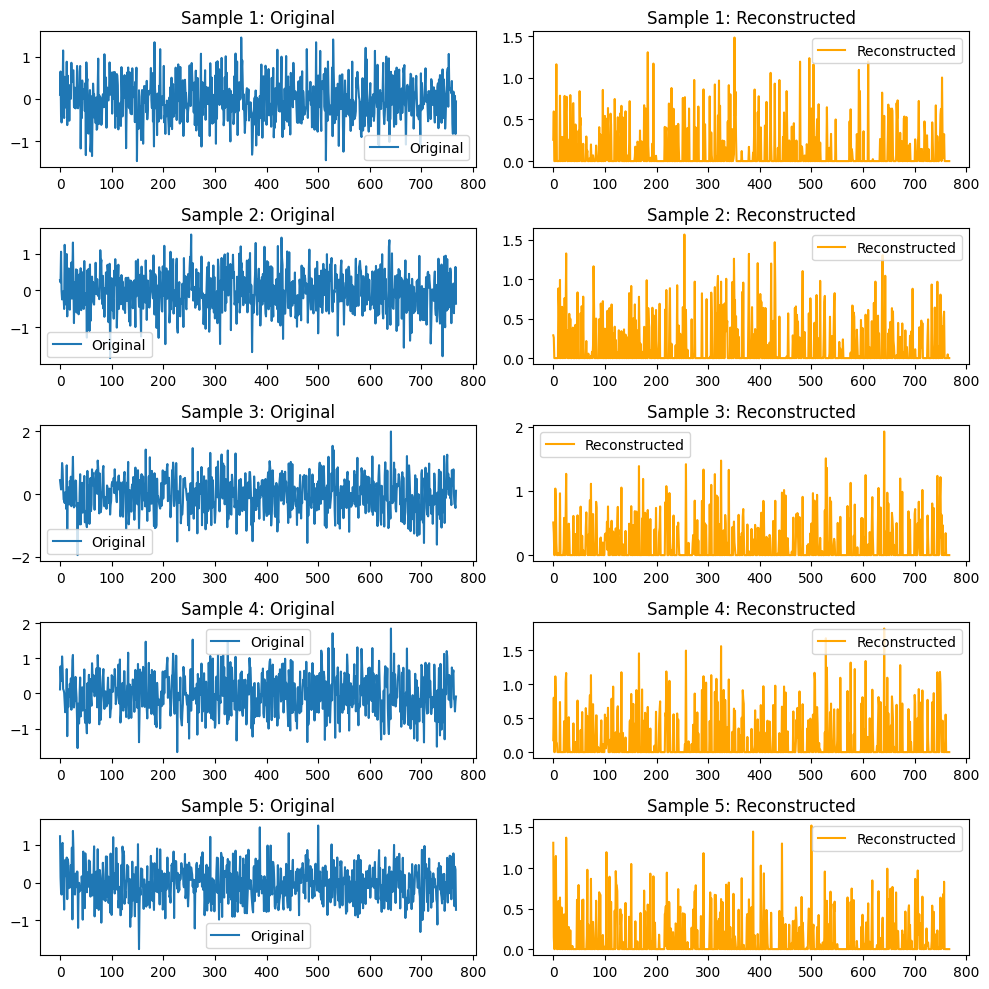

In [ ]:
test_data = quora_data.sample(n=100)
test_questions = test_data[['question1', 'question2']]

encoded_questions = model.encode(test_questions.values.flatten().tolist())

test_data_tensor = torch.tensor(encoded_questions, dtype=torch.float32).to(device)

print("Test Data Tensor Shape:", test_data_tensor.shape)



reconstructed_data = autoencoder(test_data_tensor)

reconstructed_data = reconstructed_data[1].cpu().detach().numpy()

num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2*num_samples))

for i in range(num_samples):
    original_sample = test_data_tensor[i].cpu().detach().numpy()
    reconstructed_sample = reconstructed_data[i]

    axes[i, 0].plot(original_sample, label='Original')
    axes[i, 0].set_title(f'Sample {i+1}: Original')
    axes[i, 0].legend()

    axes[i, 1].plot(reconstructed_sample, label='Reconstructed', color='orange')
    axes[i, 1].set_title(f'Sample {i+1}: Reconstructed')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# type(decoded_data)
type(test_data_tensor)

torch.Tensor

In [ ]:
test_data_tensor.shape

torch.Size([200, 768])

In [ ]:
reconstruction_loss = nn.MSELoss()
decoded_data_tensor = torch.tensor(reconstructed_data[1], dtype=torch.float32).to(device)

mse_loss = reconstruction_loss(decoded_data_tensor, test_data_tensor.mean(dim=0))

rmse_loss = torch.sqrt(mse_loss)

mae_loss_fn = nn.L1Loss()
mae_loss = mae_loss_fn(decoded_data_tensor, test_data_tensor.mean(dim=0)).item()


print(f"Mean Squared Error (MSE): {mse_loss}")
print(f"Root Mean Squared Error (RMSE): {rmse_loss}")
print(f"Mean Absolute Error (MAE): {mae_loss}")


Mean Squared Error (MSE): 0.1125258058309555
Root Mean Squared Error (RMSE): 0.33544865250587463
Mean Absolute Error (MAE): 0.25001245737075806


In [ ]:
torch.save(autoencoder.state_dict(), 'LiDA_AE.pth')